# CNN_with_data_augmentation

In [37]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense ,Input,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
covid_images_dir='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
normal_images_dir='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'

In [39]:
def loadImages(path, urls, target):
  images = []
  labels = []
  for i in range(3616):
    img_path = path + "/" + urls[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img,(200, 200))
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img = img / 255.0
    images.append(img)
    labels.append(target)
  images = np.asarray(images)
  return images, labels

In [40]:
covidUrls = os.listdir(covid_images_dir)
covidImages, covidTargets = loadImages(covid_images_dir, covidUrls, 1)
print(len(covidImages))

3616


In [41]:
del covidUrls
gc.collect()


7944

In [42]:
normal_urls = os.listdir(normal_images_dir)
normalImages, normalTargets = loadImages(normal_images_dir, normal_urls, 0)
print(len(normalImages))

3616


In [43]:
del normal_urls
gc.collect()


0

In [44]:
data = np.r_[covidImages, normalImages]
data=np.expand_dims(data,axis=-1)
print(data.shape)

(7232, 200, 200, 1)


In [45]:
del normalImages,covidImages
gc.collect()


0

In [46]:
targets = np.r_[covidTargets, normalTargets]

In [47]:
targets.shape

(7232,)

In [48]:
del normalTargets,covidTargets
gc.collect()


0

In [49]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.20,random_state=0,shuffle=True)

In [50]:
del data,targets
gc.collect()

0

In [51]:

## remove vertical_flip=True,zoom_range=0.2, and try again and compare results ##
data_gen=ImageDataGenerator(
    horizontal_flip=True,
    fill_mode='nearest',

)

In [52]:
aug_images=[]
aug_labels=[]
for index,image in enumerate(x_train):
    counter=0
    # print(f'Processing image : {index + 1}')
    for i in data_gen.flow(image.reshape((1,)+image.shape),batch_size=1):
        aug_images.append(i.reshape(200,200,1))
        aug_labels.append(y_train[index])
        counter=counter+1
        if counter >= 1:
            break
    
    

In [53]:
x_train=np.concatenate((x_train,np.array(aug_images)))
y_train=np.concatenate((y_train,np.array(aug_labels)))

In [54]:
del aug_images,aug_labels
gc.collect()


0

In [55]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=10,       
    restore_best_weights=True  
)

In [56]:
inputshape=(200,200,1)

In [57]:
model = Sequential([
    Input(shape=inputshape), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    
    
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    
    
    Flatten(), 
    
    Dense(1024, activation='relu'),
#     BatchNormalization(),
    Dropout(0.2),
    
    Dense(512, activation='relu'),
#     BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])


In [58]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
model.fit(x_train, y_train,batch_size=32,epochs=100,validation_data=(x_test, y_test),callbacks=early_stopping)

Epoch 1/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 69s 156ms/step - accuracy: 0.6166 - loss: 0.6371 - val_accuracy: 0.7726 - val_loss: 0.4846
Epoch 2/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.7731 - loss: 0.4652 - val_accuracy: 0.8162 - val_loss: 0.3915
Epoch 3/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.8213 - loss: 0.3808 - val_accuracy: 0.8728 - val_loss: 0.3047
Epoch 4/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.8575 - loss: 0.3257 - val_accuracy: 0.8777 - val_loss: 0.2870
Epoch 5/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.8861 - loss: 0.2764 - val_accuracy: 0.9005 - val_loss: 0.2418
Epoch 6/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9036 - loss: 0.2330 - val_accuracy: 0.8424 - val_loss: 0.3432
Epoch 7/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9188 - loss: 0.1967 - val_accuracy: 0.9261 - val_loss: 0.1763
Epoch 8/100
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.9279 - loss: 

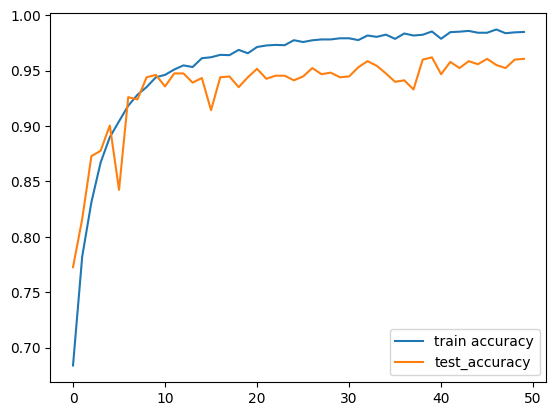

In [60]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'test_accuracy')
plt.legend()
plt.show()

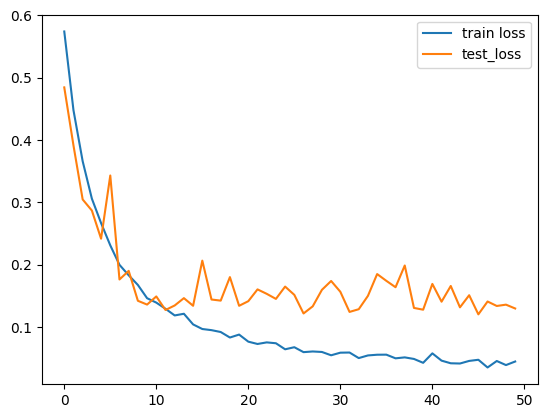

In [61]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.legend()
plt.show()

In [62]:
model.evaluate(x_test,y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9657 - loss: 0.1142


[0.12783409655094147, 0.9619902968406677]

In [63]:
y_pred = [1 if i > 0.5 else 0 for i in model.predict(x_test)]

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [64]:
accuracy_score(y_pred,y_test)

0.9619903248099516

In [65]:
precision_score(y_pred,y_test)

0.956338028169014

In [66]:
recall_score(y_pred,y_test)

0.9658605974395448

In [67]:
CM=confusion_matrix(y_pred,y_test)

<Axes: >

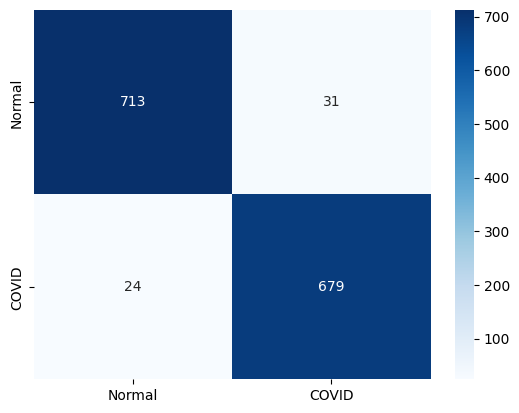

In [68]:
labels = ['Normal', 'COVID']
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

In [69]:
incorrect_predictions = []

In [70]:
for i, (p, e) in enumerate(zip(y_pred, y_test)):
    predicted, expected = p, e
    
    if predicted != expected:
        incorrect_predictions.append((i, x_test[i], predicted, expected))

In [71]:
len(incorrect_predictions)

55

In [72]:
figure, axes = plt.subplots(nrows=9, ncols=9, figsize=(150, 120))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image,cmap='gray')
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(f'index: {index}\np: {"covid" if predicted==1 else "normal"}; e: { "covid" if expected==1 else "normal" }',fontsize=100)
plt.tight_layout()

In [73]:
model.save('covidmodel.keras')

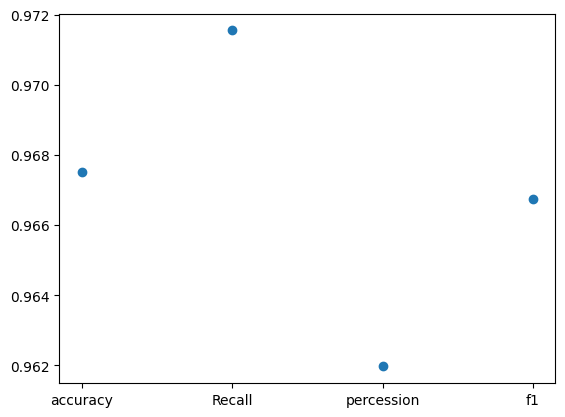

In [74]:
plt.scatter(evaluation_metric.keys(),evaluation_metric.values())
plt.show()